In [11]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.patches as mpatches
from cycler import cycler

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap


In [2]:
df1 = pd.read_csv('polygon1.csv') #demografia 
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [3]:
len(df)

4550

In [4]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 
    inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests = inData.requests
    inData.requests = my_requests
    # inData.requests.to_csv("check.csv")
    inData = ExMAS.main(inData, params)
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/1/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs



params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003
params.pax_delay = 15
params.max_degree = 4
params.price = 1.5
results = dict()
 
#    hubs 

    
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.88948])),
        ('hub2', ox.get_nearest_node(inData.G,[50.030129, 19.913131]))]#('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.88948])),





for frac in  [0.001]: #list of frac 0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.05
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.001 1
26-09-24 11:57:43-INFO-Initializing pairwise trip shareability between 4 and 4 trips.
26-09-24 11:57:43-INFO-creating combinations
26-09-24 11:57:43-INFO-12	 nR*(nR-1)
26-09-24 11:57:43-INFO-Reduction of feasible pairs by 91.67%
26-09-24 11:57:43-INFO-Degree 2 	Completed
26-09-24 11:57:43-INFO-trips to extend at degree 2 : 2
26-09-24 11:57:43-INFO-At degree 2 feasible extensions found out of 0 searched
26-09-24 11:57:43-INFO-Degree 3 	Completed
26-09-24 11:57:43-INFO-No more trips to exted at degree 3
26-09-24 11:57:43-INFO-Matching 4 trips to 6 rides in order to minimize u_veh
26-09-24 11:57:43-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,912 
reduced by matching to:                1,780
26-09-24 11:57:43-INFO-Calculations  completed
26-09-24 11:57:43-INFO-DotMap(VehHourTrav=1765, VehHourTrav_ns=1912, PassHourTrav=1933, PassHourTrav_ns=1912, PassUtility=22.704600000000003, PassUtility_ns=22.954500000000003, mean_lambda=0.275, revenue_s=2294.4,

# len(df)

In [5]:
results = {}
for num, frac, rep in list(itertools.product([1,2], [0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03], range(10))):
    results[str((num, frac, rep))] = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/1/result1_D0-03(10).csv')

In [6]:
pd.read_csv('res/1/result1_D0-03(10).csv', header=None).T.to_csv('res/1/resultT1_D0-03(10).csv', header=False, index=False)

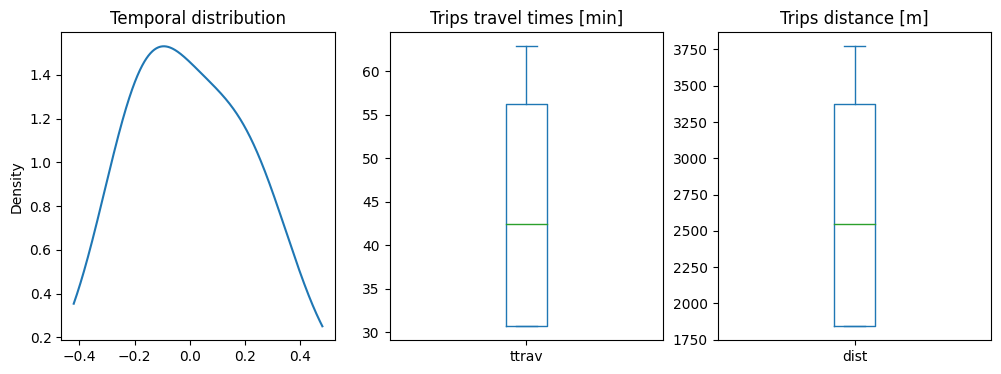

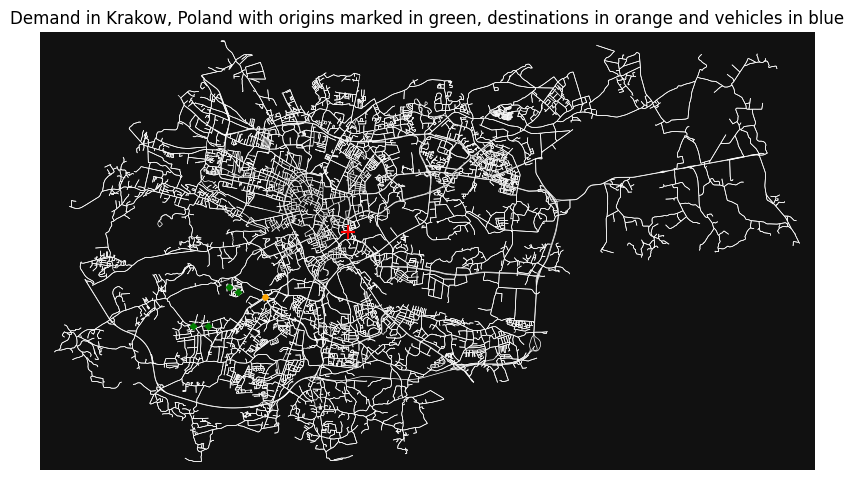

In [7]:
ExMAS.utils.plot_demand(inData, params)

In [8]:
dfT1 = pd.read_csv('res/1/resultT1_D0-03(10).csv', index_col=0) # discount 0.2

dfT1['del_VehHourTrav']=abs(dfT1['VehHourTrav']-dfT1['VehHourTrav_ns'])/dfT1['VehHourTrav_ns']           # KPI1: vehicle hours reduction
dfT1['del_PassUtility']=abs((dfT1['PassUtility']-dfT1['PassUtility_ns'])/dfT1['PassUtility_ns'])      # KPI2: travellers utility gains
dfT1['Occupancy']=dfT1['PassHourTrav']/dfT1['VehHourTrav']                                       # KPI4: occupancy
dfT1['del_PassHourTrav']=abs((dfT1['PassHourTrav']-dfT1['PassHourTrav_ns'])/dfT1['PassHourTrav_ns'])  # KPI5: passenger hours increase
dfT1['del_fleet_size']=abs((dfT1['fleet_size_shared']-dfT1['fleet_size_nonshared'])/dfT1['fleet_size_nonshared'])  # KPI6: potential fleet size reduction                  
                  
dfT1['frac'] = round((dfT1['nR'] / 4550),3) #4550!!!!!!! population of 1
dfT1['VehHourTrav_average'] =dfT1['VehHourTrav'] / dfT1['nR'] 
dfT1['PassHourTrav_average'] =dfT1['PassHourTrav'] / dfT1['nR'] 

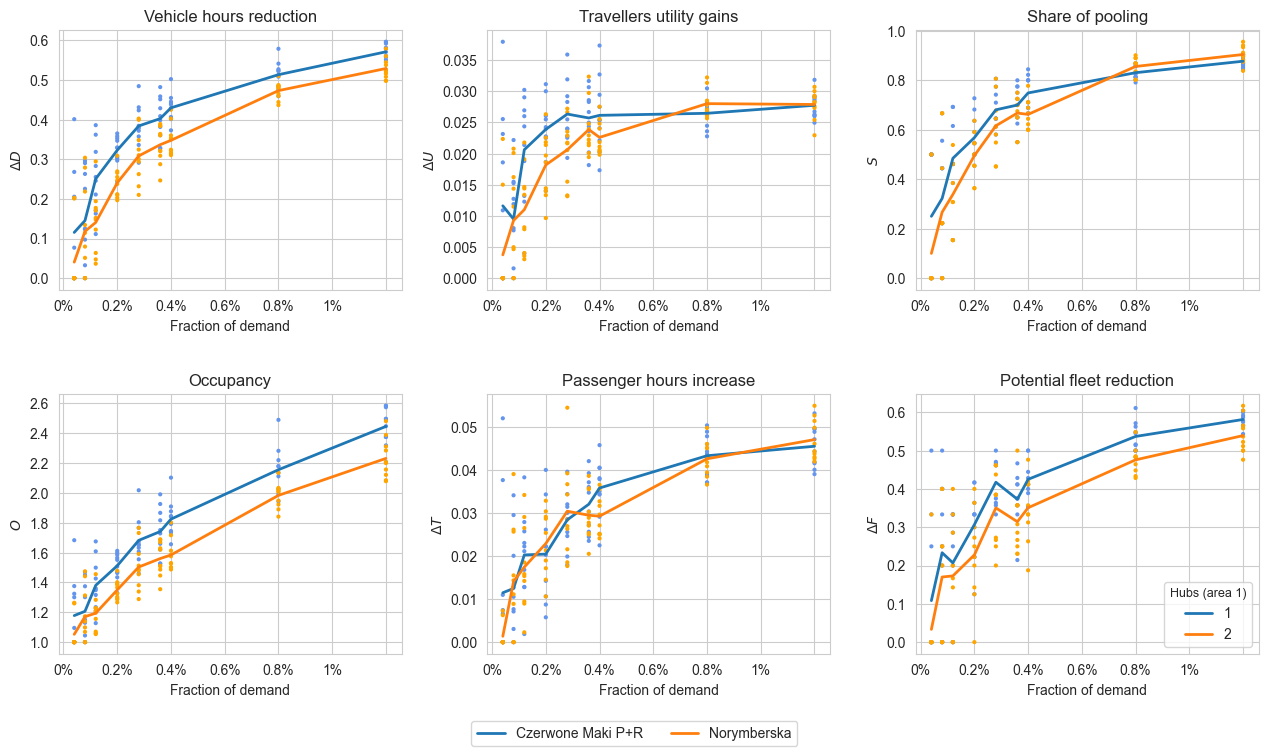

In [15]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2,3, figsize = (12,8))
axes = axes.flatten()

ax=axes[0]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_VehHourTrav'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).del_VehHourTrav.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Vehicle hours reduction", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta D$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# ax.set_xlim((0,0.05))

ax=axes[1]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_PassUtility'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).del_PassUtility.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Travellers utility gains", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta U$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# ax.set_xlim((0,0.05))

ax=axes[2]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['shared_ratio'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).shared_ratio.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Share of pooling", fontsize=12, fontweight='normal')
ax.set_ylabel("$S$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# ax.set_xlim((0,0.05))

ax=axes[3]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['Occupancy'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).Occupancy.mean().plot(ax = ax, label = f, lw = 2)

ax.set_title("Occupancy", fontsize=12, fontweight='normal')
ax.set_ylabel("$O$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# # ax.set_xlim((0,0.05))

ax=axes[4]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    # sns.regplot(data = to_plot, x = 'frac', y = 'del_PassHourTrav', x_jitter=0.005, ci=0,
    #             scatter_kws = {'s':0.6, 'alpha':0.6}, ax = ax, line_kws = {'lw':0})
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_PassHourTrav'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).del_PassHourTrav.mean().plot(ax = ax, label = f, lw = 2)

# ax.legend(title='Hubs (area 9)', loc='upper right', title_fontsize='9')
ax.set_title("Passenger hours increase", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta T$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# ax.set_xlim((0,0.05))

ax=axes[5]
for f in dfT1.hub.unique():
    to_plot = dfT1[(dfT1.hub == f)]
    dfT1[(dfT1.hub == f)].groupby(dfT1.frac).del_fleet_size.mean().plot(ax = ax, label = f, lw = 2)
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_fleet_size'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
               
ax.legend(title='Hubs (area 1)', loc='lower right', title_fontsize='9')
ax.set_title("Potential fleet reduction", fontsize=12, fontweight='normal')
ax.set_ylabel("$\Delta F$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )
# ax.set_xlim((0,0.051))

plt.subplots_adjust(left=0,
                    bottom=0.12, 
                    right=1, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)


labels = ['Czerwone Maki P+R', 
'Norymberska']

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', ncol=3)
# plt.savefig('res/9_D0_01(20)++.jpg', bbox_inches='tight', dpi=100)